In [ ]:
# Import the necessary library 

# 🔌 System & Utilities
import os
import zipfile
import gdown

# 🧠 Core Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 🎨 Vision & Transforms
from torchvision import datasets, transforms
import timm  # Pretrained models like Efficient VIT
import torchvision

# 📊 Data Handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ⏱️ Progress Bar
from tqdm import tqdm 

In [3]:
# Check device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [6]:
# load the images form directory

train_dir = '/kaggle/working/train_data/X_train_image'

In [ ]:
# Define transformations

transform = transforms.Compose([
    transforms.Resize((288, 288)),      # Resize to 288x288
    transforms.ToTensor(),              # Converts to [0, 1] and changes shape to CxHxW
])


In [8]:
# Load dataset

full_dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [9]:
# total images counts 

len(full_dataset)

8621

In [10]:
# Images shape 

image, label = full_dataset[0]

full_dataset[0][0].shape  # -> image in rgb format and the size is 199

torch.Size([3, 288, 288])

In [11]:
# split the dataset as train and validation  

generator = torch.Generator().manual_seed(42) # all the time same 

train_size = int(0.9 * len(full_dataset)) # 90 percentage of food for train 

val_size = len(full_dataset) - train_size # 10 percentage  of food for validation 

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator = generator) # this random_split funtion randomly split the train and test

In [ ]:
# create dataloader for train and test 


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # train data loader

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # validation data loader 

In [13]:
# Image counts 

# training counts 
train_count = sum([len(batch[0]) for batch in train_loader])

# validation counts
val_count = sum([len(batch[0]) for batch in val_loader])

# Print statement 
print("Train images loaded:", train_count, '\n')
print("Val images loaded:", val_count, '\n')
print("Total images:", train_count + val_count)

Train images loaded: 7758 

Val images loaded: 863 

Total images: 8621


In [15]:
# classes 

# train classes 
print(f'Train classes: {train_dataset.dataset.classes}')

print()

# val classes 
print(f'Validation classes: {val_dataset.dataset.classes}')

Train classes: ['8-cell Grade A', '8-cell Grade B', '8-cell Grade C', 'Blastocyst Grade A', 'Blastocyst Grade B', 'Blastocyst Grade C', 'Error Images', 'Morula Grade A', 'Morula Grade B', 'Morula Grade C']

Validation classes: ['8-cell Grade A', '8-cell Grade B', '8-cell Grade C', 'Blastocyst Grade A', 'Blastocyst Grade B', 'Blastocyst Grade C', 'Error Images', 'Morula Grade A', 'Morula Grade B', 'Morula Grade C']


### **Randomly show the images in both train and val**

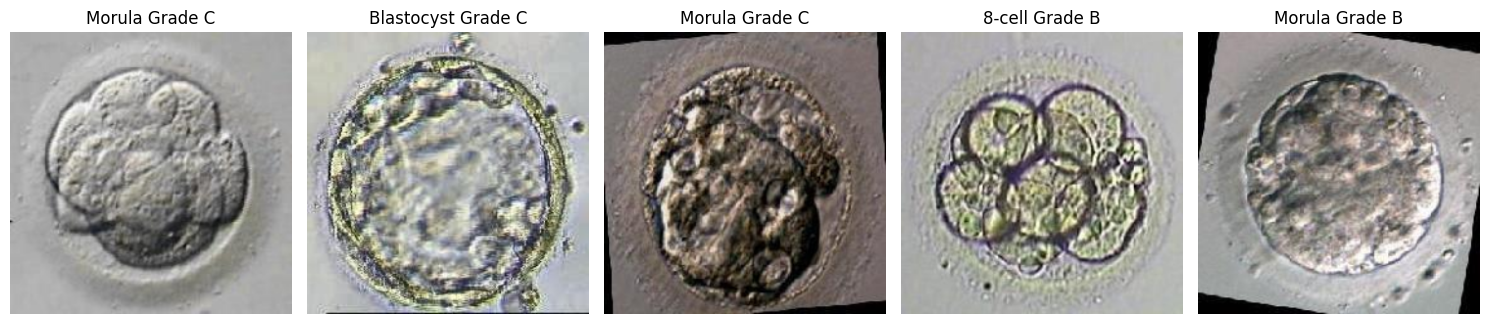

In [16]:
# train data 

dataiter = iter(train_loader)
images, labels = next(dataiter)

class_names = train_dataset.dataset.classes  

plt.figure(figsize=(15, 6))
for i in range(5):
    img = images[i]        
    label = labels[i].item()
    
    img = img.permute(1, 2, 0)  
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

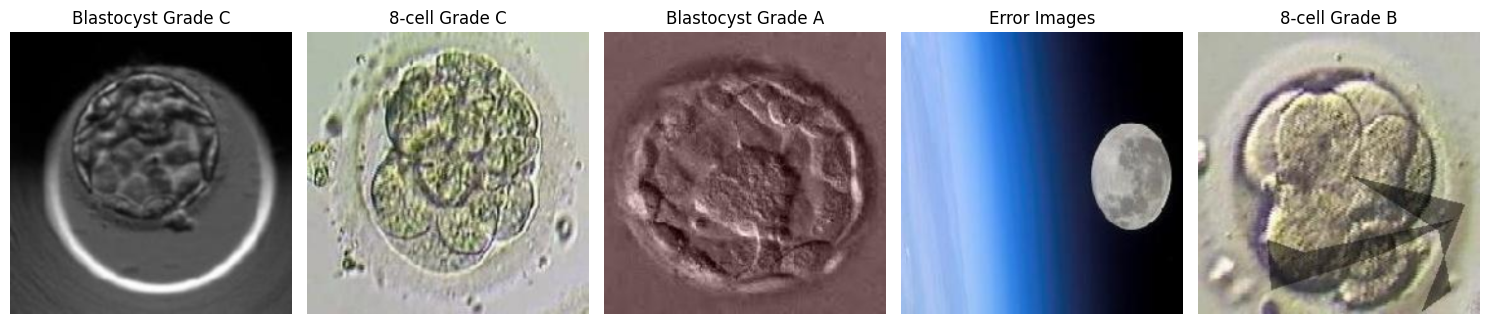

In [17]:
# val data 

dataiter = iter(val_loader)
images, labels = next(dataiter)

class_names = val_dataset.dataset.classes  

plt.figure(figsize=(15, 6))
for i in range(5):
    img = images[i]        
    label = labels[i].item()
    
    img = img.permute(1, 2, 0)  
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Phase

In [ ]:
# Load Swin Transformer V2

model = timm.create_model('efficientvit_b2.r288_in1k', pretrained=True)
model.to(device)

print("model sucessfully loaded ✅")

model sucessfully loaded ✅


In [24]:
# Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# reduce learining rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [25]:
# Trackers

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [26]:
# Early stopping

best_val_loss = float('inf')
patience = 20
wait = 0

In [27]:
for epoch in range(100):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"\nEpoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")

    # ⬇️ Reduce LR if no improvement
    scheduler.step(avg_val_loss)

    # Early stopping and best model save
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved Best Model")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping")
            break


100%|██████████| 243/243 [02:34<00:00,  1.57it/s]



Epoch 1: Train Loss=0.9772, Train Acc=0.6790, Val Loss=0.3510, Val Acc=0.8772
✅ Saved Best Model


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 2: Train Loss=0.1653, Train Acc=0.9487, Val Loss=0.2769, Val Acc=0.9131
✅ Saved Best Model


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 3: Train Loss=0.0636, Train Acc=0.9818, Val Loss=0.2396, Val Acc=0.9316
✅ Saved Best Model


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 4: Train Loss=0.0396, Train Acc=0.9889, Val Loss=0.1875, Val Acc=0.9421
✅ Saved Best Model


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 5: Train Loss=0.0309, Train Acc=0.9899, Val Loss=0.3043, Val Acc=0.9131


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 6: Train Loss=0.0343, Train Acc=0.9898, Val Loss=0.2443, Val Acc=0.9351


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 7: Train Loss=0.0258, Train Acc=0.9921, Val Loss=0.1854, Val Acc=0.9421
✅ Saved Best Model


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 8: Train Loss=0.0328, Train Acc=0.9911, Val Loss=0.2386, Val Acc=0.9409


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 9: Train Loss=0.0225, Train Acc=0.9927, Val Loss=0.3996, Val Acc=0.8888


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 10: Train Loss=0.0276, Train Acc=0.9908, Val Loss=0.2928, Val Acc=0.9235


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 11: Train Loss=0.0269, Train Acc=0.9918, Val Loss=0.2164, Val Acc=0.9397


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 12: Train Loss=0.0136, Train Acc=0.9960, Val Loss=0.1871, Val Acc=0.9490


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 13: Train Loss=0.0059, Train Acc=0.9976, Val Loss=0.1734, Val Acc=0.9594
✅ Saved Best Model


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 14: Train Loss=0.0081, Train Acc=0.9969, Val Loss=0.1718, Val Acc=0.9548
✅ Saved Best Model


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 15: Train Loss=0.0075, Train Acc=0.9969, Val Loss=0.1827, Val Acc=0.9513


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 16: Train Loss=0.0051, Train Acc=0.9978, Val Loss=0.1994, Val Acc=0.9537


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 17: Train Loss=0.0070, Train Acc=0.9968, Val Loss=0.1830, Val Acc=0.9525


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 18: Train Loss=0.0052, Train Acc=0.9976, Val Loss=0.1899, Val Acc=0.9502


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 19: Train Loss=0.0045, Train Acc=0.9982, Val Loss=0.1950, Val Acc=0.9502


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 20: Train Loss=0.0037, Train Acc=0.9982, Val Loss=0.2095, Val Acc=0.9479


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 21: Train Loss=0.0036, Train Acc=0.9982, Val Loss=0.1964, Val Acc=0.9455


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 22: Train Loss=0.0045, Train Acc=0.9977, Val Loss=0.1968, Val Acc=0.9560


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 23: Train Loss=0.0042, Train Acc=0.9982, Val Loss=0.1848, Val Acc=0.9525


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 24: Train Loss=0.0029, Train Acc=0.9988, Val Loss=0.1846, Val Acc=0.9560


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 25: Train Loss=0.0030, Train Acc=0.9987, Val Loss=0.1793, Val Acc=0.9548


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 26: Train Loss=0.0024, Train Acc=0.9990, Val Loss=0.1837, Val Acc=0.9571


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 27: Train Loss=0.0018, Train Acc=0.9995, Val Loss=0.1885, Val Acc=0.9594


100%|██████████| 243/243 [02:37<00:00,  1.55it/s]



Epoch 28: Train Loss=0.0020, Train Acc=0.9990, Val Loss=0.1933, Val Acc=0.9560


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 29: Train Loss=0.0021, Train Acc=0.9988, Val Loss=0.2009, Val Acc=0.9560


100%|██████████| 243/243 [02:38<00:00,  1.54it/s]



Epoch 30: Train Loss=0.0021, Train Acc=0.9992, Val Loss=0.2025, Val Acc=0.9525


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 31: Train Loss=0.0014, Train Acc=0.9996, Val Loss=0.2073, Val Acc=0.9525


100%|██████████| 243/243 [02:37<00:00,  1.54it/s]



Epoch 32: Train Loss=0.0017, Train Acc=0.9995, Val Loss=0.2115, Val Acc=0.9537


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 33: Train Loss=0.0018, Train Acc=0.9992, Val Loss=0.2093, Val Acc=0.9537


100%|██████████| 243/243 [02:36<00:00,  1.55it/s]



Epoch 34: Train Loss=0.0013, Train Acc=0.9997, Val Loss=0.2140, Val Acc=0.9513
⏹️ Early stopping


**Train and Validation Loss Plot**

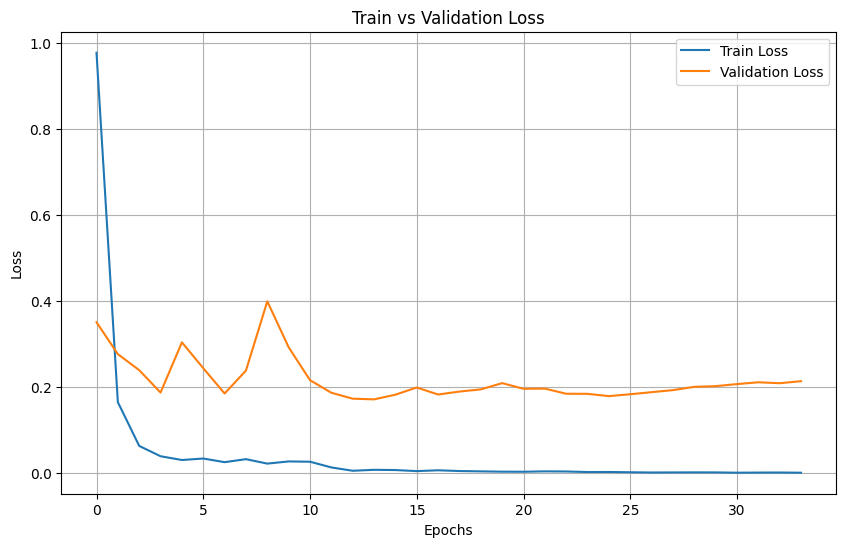

(None,)

In [29]:
# Plotting

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show(), 

**Train and Validation Accuracy Plot**

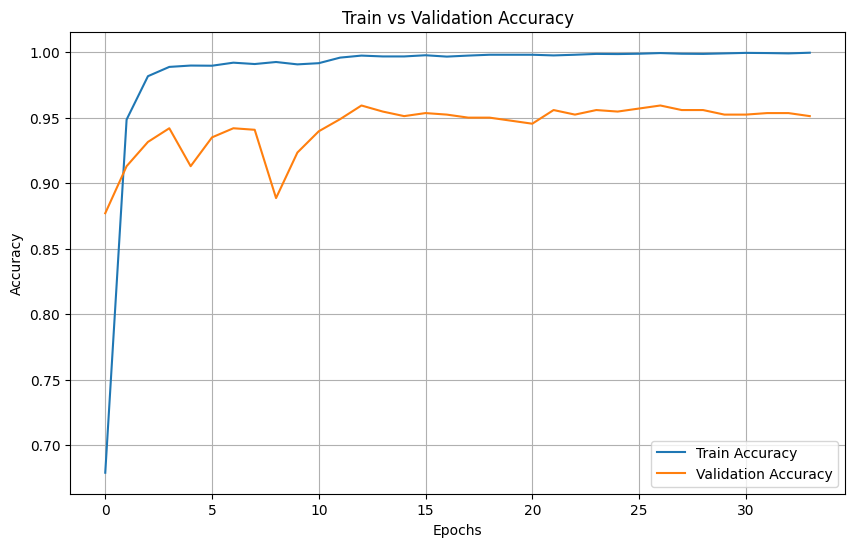

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation 

**Training Dataset**

In [32]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load test set
train_dataset = datasets.ImageFolder(root='/kaggle/working/train_data/X_train_image', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Evaluate
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\n🧪 Test Accuracy: {correct / total:.4f}")

/tmp/ipykernel_94/2683037278.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



🧪 Test Accuracy: 0.9926


# Load the model 

In [34]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load test set
test_dataset = datasets.ImageFolder(root='/kaggle/working/test_data/X_test_image', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\n🧪 Test Accuracy: {correct / total:.4f}")

/tmp/ipykernel_94/258865527.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



🧪 Test Accuracy: 0.9572


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [ ]:
from utils.MLFlowTrackingConfig import MLFlowTracking

In [17]:
MLFlowTracking(model, 288, 3, 32, False, 100, 10, 'efficientvit_b2.r288_in1k', 1e-4, 0.1718, 0.9926, 0.9572, 'efficientvit_b2.r288_in1k')

Accessing as revanth-kumar-01-ai
Initialized MLflow to track repo 
"revanth-kumar-01-ai/360DigitMG-Training-Phase"
Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!


2025/04/24 09:17:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'efficientvit_b2.r288_in1k'.
2025/04/24 09:18:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: efficientvit_b2.r288_in1k, version 1
Created version '1' of model 'efficientvit_b2.r288_in1k'.


🏃 View run debonair-bear-21 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/7853464e613f438494bf0f9e38e97e68
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
